In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# TPU support

Enable tpu with edit -> notebook settings -> tpu

For gpu support just enable edit -> notebook settings -> gpu - it should work out of the box

In [ ]:
import os
import tensorflow as tf

TPU = False

if TPU:
    tf.keras.backend.clear_session()
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']    

# Fetch data and prepare sample

* The complete training dataset has 25k images, 12.5k from cats and 12.5k from dogs.
* We use 1000 images each for training and 500 for validation / test.

## Fetch training data

In [ ]:
import os
import requests

from pathlib import Path
from tqdm import tqdm_notebook as tqdm

In [ ]:
archive_name = "cats_vs_dogs.zip"
training_data_url = "https://d2b7dn9rofvhjd.cloudfront.net/{}".format(archive_name)
data_root = Path.home() / "data" / "tmp"
data_root.mkdir(parents=True, exist_ok=True)
training_data_path = data_root / archive_name

In [ ]:
def download_from_url(url, dst, chunk_size=1024):
    """
    @param: url to download
    @param: dst path to destination file
    """
    file_size = int(requests.head(url).headers["Content-Length"])
    first_byte = dst.stat().st_size if dst.exists() else 0
    
    # return early when we are already done
    if first_byte >= file_size:
        return file_size
    
    # download first_byte to file_size
    header = {"Range": "bytes={}-{}".format(first_byte, file_size)}
    pbar = tqdm(
        total=file_size, initial=first_byte,
        unit='B', unit_scale=True, desc=url.split('/')[-1])
    req = requests.get(url, headers=header, stream=True)
    with(open(str(dst), 'ab')) as f:
        for chunk in req.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                pbar.update(chunk_size)
    pbar.close()
    return file_size

In [ ]:
file_size = download_from_url(training_data_url, training_data_path)

## Unpack archive

In [ ]:
import zipfile

In [ ]:
data_root

PosixPath('/root/data/tmp')

In [ ]:
%%time
archive = zipfile.ZipFile(str(training_data_path), 'r')
archive.extractall(str(data_root))
archive.close()

CPU times: user 7.29 s, sys: 3.03 s, total: 10.3 s
Wall time: 11.6 s


In [ ]:
training_data_path.unlink()

In [ ]:
original_data_dir = list(data_root.glob("*cats*dogs"))[0]

## Create sample data

In [ ]:
from shutil import copy

### Create directories

In [ ]:
sample_dir = data_root / "cats_vs_dogs_sample"
for part in ("test", "train", "validation"):
    for category in ("cats", "dogs"):
        (sample_dir / part / category).mkdir(parents=True, exist_ok=True)

### Copy files

In [ ]:
def copy_files_range(src_dir, dst_dir, file_template, start, stop):
    print(dst_dir)
    fnames = (file_template.format(i) for i in range(start, stop))
    for fname in fnames:
        src = src_dir / fname
        copy(str(src), str(dst_dir))

In [ ]:
%%time
file_templates = {"cats": "cat.{}.jpg", "dogs": "dog.{}.jpg"}
data_splits = (
    ("train", 0, 1000),          # Copy first 1000 images to train dirs
    ("validation", 1000, 1500),  # Copy next 500 images into validation dirs
    ("test", 1500, 2000),        # Copy next 500 images into test dirs
)

for (part, start, stop) in data_splits:
    for category in ("cats", "dogs"):
        copy_files_range(
            original_data_dir,
            sample_dir / part / category,
            file_templates[category],
            start,
            stop
        )

/root/data/tmp/cats_vs_dogs_sample/train/cats
/root/data/tmp/cats_vs_dogs_sample/train/dogs
/root/data/tmp/cats_vs_dogs_sample/validation/cats
/root/data/tmp/cats_vs_dogs_sample/validation/dogs
/root/data/tmp/cats_vs_dogs_sample/test/cats
/root/data/tmp/cats_vs_dogs_sample/test/dogs
CPU times: user 384 ms, sys: 568 ms, total: 951 ms
Wall time: 962 ms


In [ ]:
for part in ("train", "validation", "test"):
    for category in ("cats", "dogs"):
        desc = "total {} images of {}:".format(part, category)
        num_files_in_dir = len(list((sample_dir / part / category).iterdir()))
        print(desc.ljust(35), num_files_in_dir)

total train images of cats:         1000
total train images of dogs:         1000
total validation images of cats:    500
total validation images of dogs:    500
total test images of cats:          500
total test images of dogs:          500


# Set up directories

In [ ]:
from pathlib import Path
data_root = Path.home() / "data" / "tmp"
sample_dir = data_root / "cats_vs_dogs_sample"

# Train model from scratch

## Create model

For gpu support enable edit -> notebook settings -> gpu - it should work out of the box

In [ ]:
if TPU:
    from tensorflow.python.keras import layers
    from tensorflow.python.keras import models
else:
    from keras import layers
    from keras import models


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

if TPU:
    model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [ ]:
if TPU:
    from tensorflow.train import RMSPropOptimizer
    model.compile(loss='binary_crossentropy',
              optimizer=RMSPropOptimizer(1e-4),
              metrics=['acc'])
else:
    from keras import optimizers
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

## Create training data generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        str(sample_dir / "train"),
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        str(sample_dir / "validation"),
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Fit model

In [ ]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 13s 132ms/step - loss: 0.6896 - acc: 0.5195 - val_loss: 0.6723 - val_acc: 0.5920
Epoch 2/30
100/100 [==============================] - 11s 107ms/step - loss: 0.6486 - acc: 0.6240 - val_loss: 0.6861 - val_acc: 0.5750
Epoch 3/30
100/100 [==============================] - 11s 106ms/step - loss: 0.5990 - acc: 0.6730 - val_loss: 0.5927 - val_acc: 0.6750
Epoch 4/30
100/100 [==============================] - 10s 105ms/step - loss: 0.5628 - acc: 0.7175 - val_loss: 0.5836 - val_acc: 0.6790
Epoch 5/30
100/100 [==============================] - 11s 106ms/step - loss: 0.5297 - acc: 0.7355 - val_loss: 0.5609 - val_acc: 0.7060
Epoch 6/30
100/100 [==============================] - 11s 107ms/step - loss: 0.5058 - acc: 0.7575 - val_loss: 0.5671 - val_acc: 0.6970
Epoch 7/30
100/100 [==============================] - 11s 105ms/step - loss: 0.4816 - acc: 0.7730 - val_loss: 0.6251 - val_acc: 0.6910
Epoch 8

In [ ]:
if TPU:
  # need to decode non json serializable float32 :/
  my_history = {}
  for key, values in history.history.items():
    my_history[key] = [float(_) for _ in values]
else:
  my_history = history.history

In [ ]:
import json

models_dir = data_root / "models" 
models_dir.mkdir(exist_ok=True)
model.save(str(models_dir / "cats_and_dogs_small_from_scratch.h5"))

history_path = models_dir / "cats_and_dogs_small_from_scratch_history.json"
with open(str(history_path), "w") as f:
    json.dump(my_history, f)

In [ ]:
history = json.load(open(str(history_path)))

## Plot training vs test accuracy

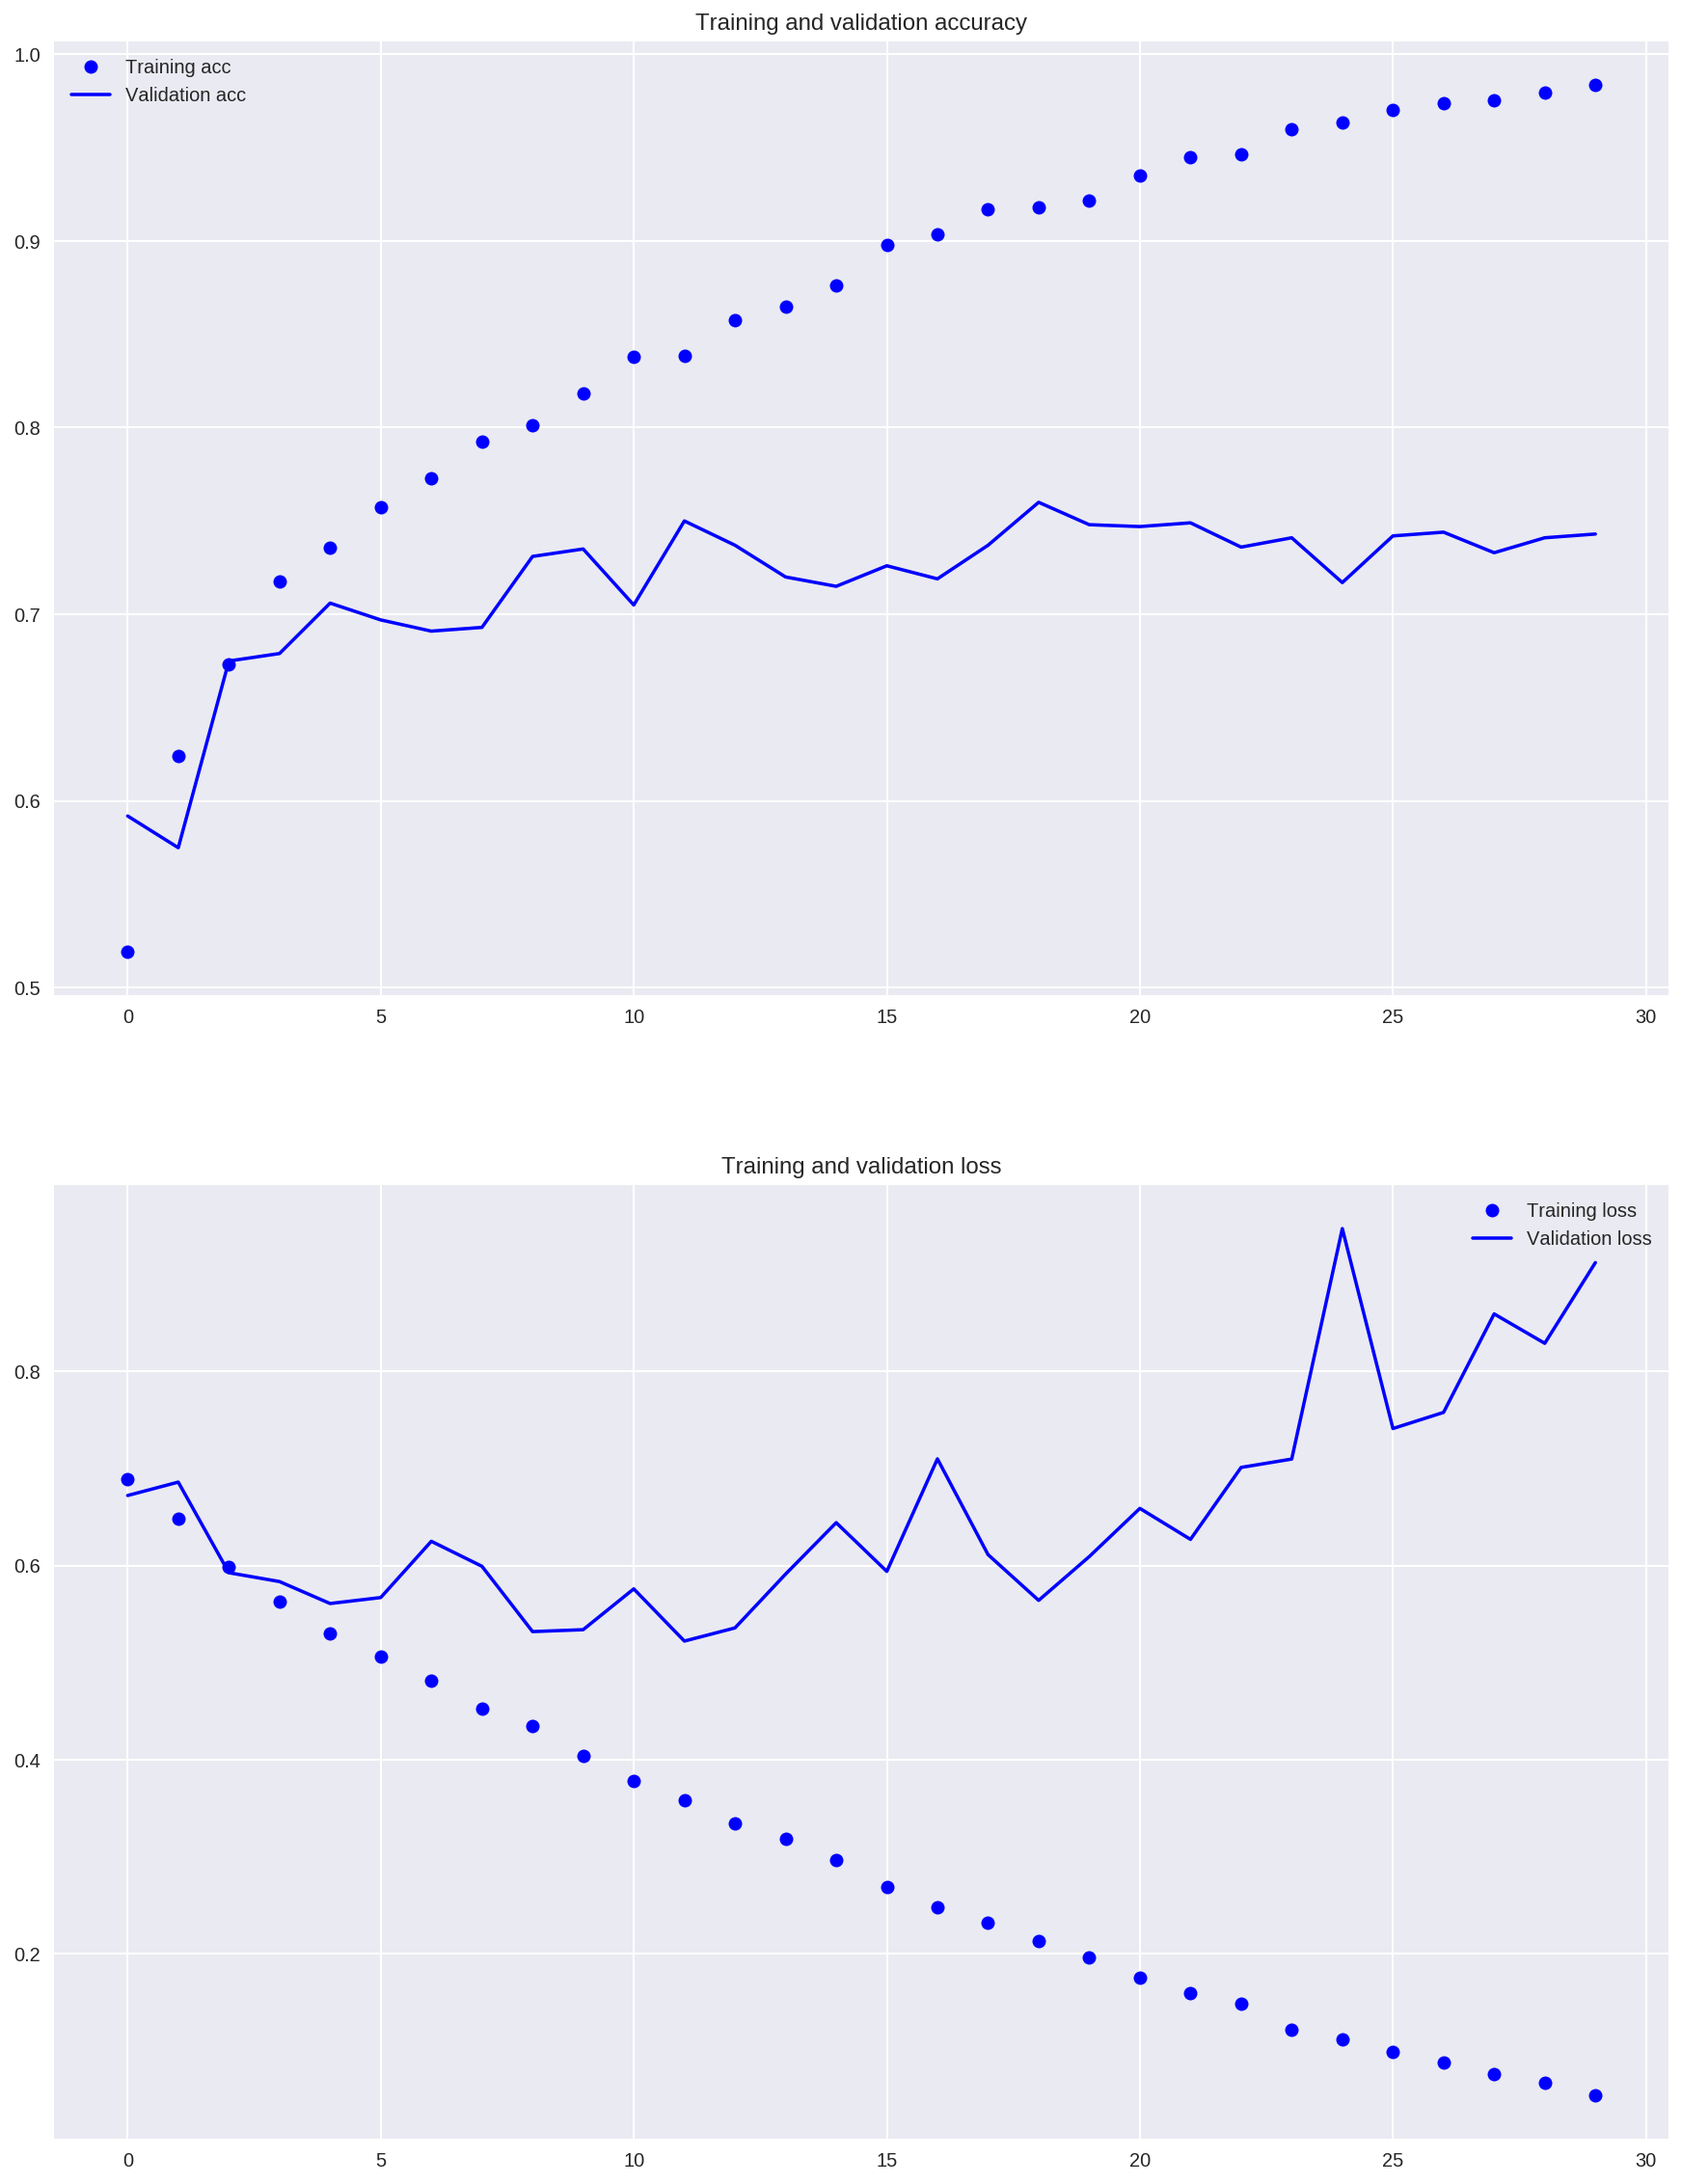

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 20))

plt.subplot(211)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()